# Notebook setup

In [2]:
import os
import sys
sys.path.append(os.path.abspath("../../src"))

In [55]:
import random
import numpy as np
import pandas as pd
from math import ceil, log2
from tqdm import tqdm
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from circuit import quantum_galton_board as qgb

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Classes and functions

In [4]:
# Deep learning model
class FeedForwardNN(torch.nn.Module):
    """
    Simple Feed-Forward Neural Network
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()

        # Define layers
        self.fc1 = torch.nn.Linear(input_size, hidden_size) # Linear function - fully connected
        self.relu = torch.nn.ReLU()  # Non-linearity
        self.fc2 = torch.nn.Linear(hidden_size, output_size)  # Linear function (readout) - fully connected
        self.sigmoid = torch.nn.Sigmoid()  # Force the outputs between [0,1)

    def forward(self, x):
        # Define forward pass
        out = self.fc1(x)  # Pass input through first layer
        out = self.relu(out)  # Apply ReLU activation
        out = self.fc2(out)  # Pass through second layer to get output
        out = self.sigmoid(out)

        return out

In [5]:
def train(X, Y, X_idx_array, model, batch_size, device, optimizer, criterion):
    # Start training loss
    train_loss = 0
    
    for idx in range(0, X.shape[0], batch_size):
        # Get the corresponding data
        indices = X_idx_array[idx:idx + batch_size]
        inputs = torch.from_numpy(X[indices, :]).float()
        labels = torch.from_numpy(Y[indices, :]).float()
        
        # Move them to the device
        inputs.to(device)
        labels.to(device)
        
        # Zero the gradients from the previous iteration
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Compute gradients
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Add to the training loss
        train_loss += loss.item()
        
    return train_loss

In [6]:
def validate(X, Y, model, batch_size, device, criterion):
    # Start validation loss
    val_loss = 0
    
    with torch.no_grad():
        for idx in range(0, X.shape[0], batch_size):
            # Get the corresponding data
            inputs = torch.from_numpy(X[idx:idx + batch_size, :]).float()
            labels = torch.from_numpy(Y[idx:idx + batch_size, :]).float()

            # Move them to the device
            inputs.to(device)
            labels.to(device)
            
            # Compute validation loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    return val_loss

In [7]:
def bar_plot(df):
    df_rst = df.reset_index()
    df_rst.columns = ["state", "value"]
    df_rst["state_idx"] = df_rst["state"].apply(lambda x: int(str(x), 2))
    df_rst_sort = df_rst.sort_values(by="state_idx", ascending=True)

    plt.bar(df_rst_sort["state"], df_rst_sort["value"])
    plt.xticks(rotation=45)
    plt.show()

In [8]:
def discretize(data, bins):
    # Get the count of data points on equally spaced bins
    hist_counts, _ = np.histogram(data, bins=bins, range=(data.min(), data.max()), density=False)
    
    return hist_counts

# Dataset exploration

In [9]:
# Read in files
lvl9 = pd.read_csv("../../data/raw/obs_counts_levels9_shots10000_sims1000.csv")

lvl9

,prob1,prob2,prob3,prob4,prob5,prob6,prob7,prob8,prob9,prob10,...,prob36,000000100,000001000,000010000,000100000,001000000,010000000,100000000,000000001,000000010
0,0.367103,0.717980,0.744644,0.804921,0.903110,0.757841,0.698560,0.528500,0.826198,0.963865,...,0.690496,29,1077,1756,4637,1181,1276.0,44.0,0.0,0.0
1,0.627017,0.082686,0.794516,0.799850,0.844305,0.109229,0.925668,0.327953,0.623292,0.394676,...,0.902476,279,840,2908,3746,1983,101.0,0.0,8.0,135.0
2,0.032669,0.711463,0.577852,0.279925,0.682792,0.514008,0.210887,0.608127,0.689785,0.422955,...,0.223669,598,3064,2485,1392,2138,48.0,4.0,26.0,245.0
3,0.067868,0.546449,0.477913,0.496354,0.546776,0.799137,0.159281,0.313864,0.818686,0.249512,...,0.911878,917,1806,3245,2695,858,13.0,0.0,8.0,458.0
4,0.775024,0.188495,0.308958,0.233842,0.567672,0.470703,0.803212,0.459137,0.166727,0.509305,...,0.631924,2273,3575,1185,1054,1717,17.0,7.0,12.0,160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.803567,0.171100,0.514649,0.880852,0.708292,0.047713,0.395683,0.175275,0.955119,0.992570,...,0.992976,462,1536,4222,2690,825,212.0,16.0,0.0,37.0
996,0.483854,0.365342,0.295294,0.575479,0.004690,0.161465,0.802407,0.104339,0.087506,0.816582,...,0.586578,3577,1500,3216,916,128,115.0,1.0,47.0,500.0
997,0.414268,0.260290,0.253679,0.772757,0.334404,0.607893,0.091447,0.601415,0.587807,0.597125,...,0.769184,645,6116,781,1271,328,90.0,4.0,80.0,685.0
998,0.763494,0.884144,0.154179,0.441784,0.029327,0.767017,0.308240,0.327640,0.177787,0.765913,...,0.163432,1088,1114,2828,221,2960,1321.0,186.0,4.0,278.0


In [10]:
# Split into features and targets
features = lvl9.iloc[:, 36:]  # Circuits' observations
targets = lvl9.iloc[:, :36]  # probabilities/biases used for the pegs

# Sort features columns by their state
states_int_dict = {col: int(col, 2) for col in features.columns}
sorted_states = sorted(states_int_dict, key=states_int_dict.get)
features = features[sorted_states]

# Print circuit outputs only
features

,000000001,000000010,000000100,000001000,000010000,000100000,001000000,010000000,100000000
0,0.0,0.0,29,1077,1756,4637,1181,1276.0,44.0
1,8.0,135.0,279,840,2908,3746,1983,101.0,0.0
2,26.0,245.0,598,3064,2485,1392,2138,48.0,4.0
3,8.0,458.0,917,1806,3245,2695,858,13.0,0.0
4,12.0,160.0,2273,3575,1185,1054,1717,17.0,7.0
...,...,...,...,...,...,...,...,...,...
995,0.0,37.0,462,1536,4222,2690,825,212.0,16.0
996,47.0,500.0,3577,1500,3216,916,128,115.0,1.0
997,80.0,685.0,645,6116,781,1271,328,90.0,4.0
998,4.0,278.0,1088,1114,2828,221,2960,1321.0,186.0


On average it behaves like a normal distribution.

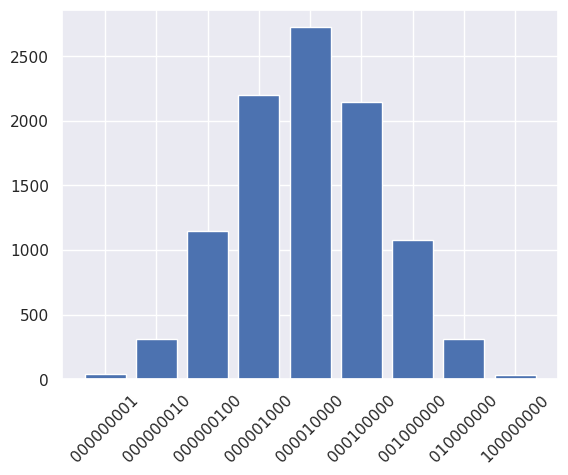

In [11]:
# Plot the mean counts of every state
bar_plot(features.mean())

But an individual run of the circuit may not look normal.

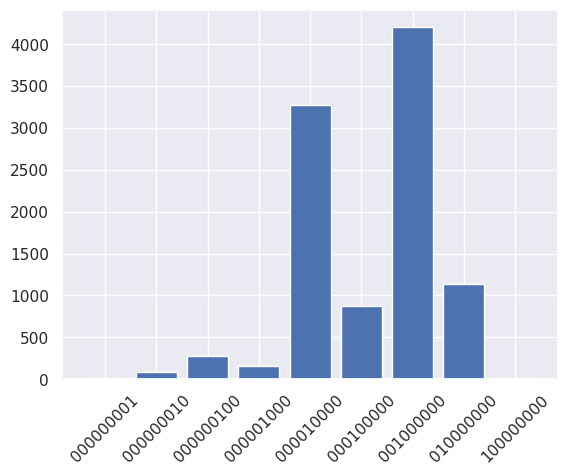

In [12]:
# Plot a randomly selected run output
random_sim = np.random.randint(0, features.shape[0])
features_rand = features.iloc[random_sim, :]

bar_plot(features_rand)

Distribution of probabilities used show that they values approximate a uniform distribution. This means that any random combination of probabilities could have been used for any given simulation.

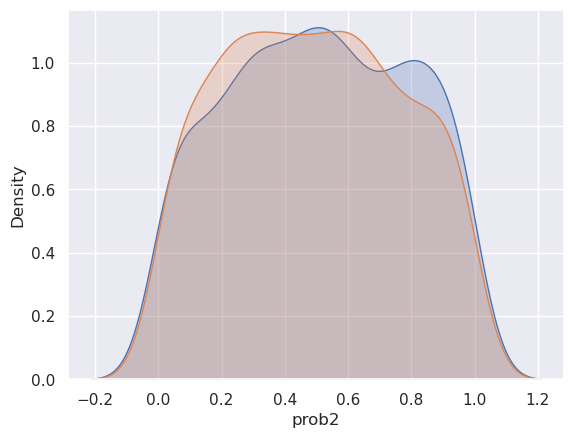

In [13]:
# Distribution plot of some of the probabilities used on the simulations
for pval_col in targets.columns[[1,15]]:
    sns.kdeplot(targets[pval_col], fill=True)

plt.show()

# Data procesing

In [14]:
# Split to get training data (70%)
features_train, features_temp, targets_train, targets_temp = train_test_split(features.to_numpy(), 
                                                                              targets.to_numpy(), 
                                                                              test_size=0.3, 
                                                                              random_state=1925)

# Further split to get testing (15%) and validation (15%) data
features_val, features_test, targets_val, targets_test = train_test_split(features_temp, 
                                                                          targets_temp, 
                                                                          test_size=0.5, 
                                                                          random_state=1925)

print(f"Shape of training data: {features_train.shape}")
print(f"Shape of validation data: {features_val.shape}")
print(f"Shape of testing data: {features_test.shape}")

Shape of training data: (700, 9)
Shape of validation data: (150, 9)
Shape of testing data: (150, 9)


In [15]:
# Fit the scaler with the training data
scaler = StandardScaler()
scaler.fit(features_train)

# Transform all features with the same scaler to avoid data leakage
features_train = scaler.transform(features_train)
features_val = scaler.transform(features_val)
features_test = scaler.transform(features_test)

# Train

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make an instance of the model, loss function and optimizer
hs = int((features.shape[1] + targets.shape[1])/2)  # A size between the one of the input and output layers
model = FeedForwardNN(input_size=features_train.shape[1], hidden_size=hs, output_size=targets_train.shape[1])
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training parameters
num_epochs = 250
batch_size = 32
num_train_batches = ceil(features_train.shape[0] / batch_size)
num_val_batches = ceil(features_val.shape[0] / batch_size)

# Lists to store all cumulative losses
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    # Training phase
    model.train()
    
    # Shuffle training simulations
    features_idx = list(range(features_train.shape[0]))
    random.shuffle(features_idx)
    features_idx_arr = np.array(features_idx)
    
    # Train the model
    train_loss = train(features_train, targets_train, features_idx_arr, 
                       model, batch_size, device, optimizer, criterion)
    
    # Normalize the training loss over the number of batches
    train_loss = train_loss / num_train_batches
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    
    # Validate the model
    val_loss = validate(features_val, targets_val, model, batch_size, device, criterion)
    
    # Normalize the validation loss over the number of batches
    val_loss = val_loss / num_val_batches
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

  9%|▉         | 23/250 [00:00<00:02, 113.26it/s]

Epoch [1/250], Training Loss: 64.4387, Validation Loss: 64.3955
Epoch [2/250], Training Loss: 64.4393, Validation Loss: 64.3926
Epoch [3/250], Training Loss: 64.4410, Validation Loss: 64.3898
Epoch [4/250], Training Loss: 64.4265, Validation Loss: 64.3871
Epoch [5/250], Training Loss: 64.4313, Validation Loss: 64.3844
Epoch [6/250], Training Loss: 64.4358, Validation Loss: 64.3818
Epoch [7/250], Training Loss: 64.4127, Validation Loss: 64.3793
Epoch [8/250], Training Loss: 64.4129, Validation Loss: 64.3767
Epoch [9/250], Training Loss: 64.4149, Validation Loss: 64.3742
Epoch [10/250], Training Loss: 64.4199, Validation Loss: 64.3718
Epoch [11/250], Training Loss: 64.4102, Validation Loss: 64.3694
Epoch [12/250], Training Loss: 64.4020, Validation Loss: 64.3672
Epoch [13/250], Training Loss: 64.4073, Validation Loss: 64.3649
Epoch [14/250], Training Loss: 64.3979, Validation Loss: 64.3627
Epoch [15/250], Training Loss: 64.4007, Validation Loss: 64.3606
Epoch [16/250], Training Loss: 64.

 19%|█▉        | 47/250 [00:00<00:01, 115.76it/s]

Epoch [25/250], Training Loss: 64.3675, Validation Loss: 64.3406
Epoch [26/250], Training Loss: 64.3808, Validation Loss: 64.3387
Epoch [27/250], Training Loss: 64.3856, Validation Loss: 64.3369
Epoch [28/250], Training Loss: 64.3785, Validation Loss: 64.3350
Epoch [29/250], Training Loss: 64.3791, Validation Loss: 64.3332
Epoch [30/250], Training Loss: 64.3624, Validation Loss: 64.3313
Epoch [31/250], Training Loss: 64.3703, Validation Loss: 64.3296
Epoch [32/250], Training Loss: 64.3594, Validation Loss: 64.3278
Epoch [33/250], Training Loss: 64.3652, Validation Loss: 64.3260
Epoch [34/250], Training Loss: 64.3707, Validation Loss: 64.3244
Epoch [35/250], Training Loss: 64.3616, Validation Loss: 64.3226
Epoch [36/250], Training Loss: 64.3530, Validation Loss: 64.3208
Epoch [37/250], Training Loss: 64.3469, Validation Loss: 64.3192
Epoch [38/250], Training Loss: 64.3551, Validation Loss: 64.3174
Epoch [39/250], Training Loss: 64.3483, Validation Loss: 64.3158
Epoch [40/250], Training 

 28%|██▊       | 71/250 [00:00<00:01, 116.57it/s]

Epoch [49/250], Training Loss: 64.3356, Validation Loss: 64.2993
Epoch [50/250], Training Loss: 64.3228, Validation Loss: 64.2976
Epoch [51/250], Training Loss: 64.3350, Validation Loss: 64.2960
Epoch [52/250], Training Loss: 64.3343, Validation Loss: 64.2944
Epoch [53/250], Training Loss: 64.3286, Validation Loss: 64.2928
Epoch [54/250], Training Loss: 64.3111, Validation Loss: 64.2912
Epoch [55/250], Training Loss: 64.3164, Validation Loss: 64.2896
Epoch [56/250], Training Loss: 64.3089, Validation Loss: 64.2879
Epoch [57/250], Training Loss: 64.3171, Validation Loss: 64.2863
Epoch [58/250], Training Loss: 64.3215, Validation Loss: 64.2847
Epoch [59/250], Training Loss: 64.3020, Validation Loss: 64.2832
Epoch [60/250], Training Loss: 64.3089, Validation Loss: 64.2816
Epoch [61/250], Training Loss: 64.3093, Validation Loss: 64.2800
Epoch [62/250], Training Loss: 64.3069, Validation Loss: 64.2784
Epoch [63/250], Training Loss: 64.3052, Validation Loss: 64.2769
Epoch [64/250], Training 

 38%|███▊      | 95/250 [00:00<00:01, 116.45it/s]

Epoch [73/250], Training Loss: 64.2901, Validation Loss: 64.2612
Epoch [74/250], Training Loss: 64.2926, Validation Loss: 64.2596
Epoch [75/250], Training Loss: 64.2768, Validation Loss: 64.2581
Epoch [76/250], Training Loss: 64.2808, Validation Loss: 64.2566
Epoch [77/250], Training Loss: 64.2856, Validation Loss: 64.2551
Epoch [78/250], Training Loss: 64.2777, Validation Loss: 64.2535
Epoch [79/250], Training Loss: 64.2846, Validation Loss: 64.2520
Epoch [80/250], Training Loss: 64.2692, Validation Loss: 64.2505
Epoch [81/250], Training Loss: 64.2682, Validation Loss: 64.2489
Epoch [82/250], Training Loss: 64.2780, Validation Loss: 64.2474
Epoch [83/250], Training Loss: 64.2618, Validation Loss: 64.2459
Epoch [84/250], Training Loss: 64.2649, Validation Loss: 64.2444
Epoch [85/250], Training Loss: 64.2717, Validation Loss: 64.2429
Epoch [86/250], Training Loss: 64.2534, Validation Loss: 64.2414
Epoch [87/250], Training Loss: 64.2604, Validation Loss: 64.2399
Epoch [88/250], Training 

 48%|████▊     | 119/250 [00:01<00:01, 116.82it/s]

Epoch [97/250], Training Loss: 64.2421, Validation Loss: 64.2253
Epoch [98/250], Training Loss: 64.2371, Validation Loss: 64.2238
Epoch [99/250], Training Loss: 64.2436, Validation Loss: 64.2224
Epoch [100/250], Training Loss: 64.2258, Validation Loss: 64.2210
Epoch [101/250], Training Loss: 64.2455, Validation Loss: 64.2196
Epoch [102/250], Training Loss: 64.2310, Validation Loss: 64.2182
Epoch [103/250], Training Loss: 64.2360, Validation Loss: 64.2168
Epoch [104/250], Training Loss: 64.2220, Validation Loss: 64.2154
Epoch [105/250], Training Loss: 64.2299, Validation Loss: 64.2141
Epoch [106/250], Training Loss: 64.2187, Validation Loss: 64.2127
Epoch [107/250], Training Loss: 64.2472, Validation Loss: 64.2114
Epoch [108/250], Training Loss: 64.2149, Validation Loss: 64.2100
Epoch [109/250], Training Loss: 64.2162, Validation Loss: 64.2087
Epoch [110/250], Training Loss: 64.2330, Validation Loss: 64.2073
Epoch [111/250], Training Loss: 64.2152, Validation Loss: 64.2060
Epoch [112/25

 57%|█████▋    | 143/250 [00:01<00:00, 116.53it/s]

Epoch [121/250], Training Loss: 64.1943, Validation Loss: 64.1934
Epoch [122/250], Training Loss: 64.2146, Validation Loss: 64.1922
Epoch [123/250], Training Loss: 64.1981, Validation Loss: 64.1909
Epoch [124/250], Training Loss: 64.2130, Validation Loss: 64.1898
Epoch [125/250], Training Loss: 64.2035, Validation Loss: 64.1886
Epoch [126/250], Training Loss: 64.1959, Validation Loss: 64.1874
Epoch [127/250], Training Loss: 64.2042, Validation Loss: 64.1862
Epoch [128/250], Training Loss: 64.1910, Validation Loss: 64.1851
Epoch [129/250], Training Loss: 64.1899, Validation Loss: 64.1839
Epoch [130/250], Training Loss: 64.1981, Validation Loss: 64.1828
Epoch [131/250], Training Loss: 64.1912, Validation Loss: 64.1817
Epoch [132/250], Training Loss: 64.1956, Validation Loss: 64.1806
Epoch [133/250], Training Loss: 64.1879, Validation Loss: 64.1794
Epoch [134/250], Training Loss: 64.1848, Validation Loss: 64.1784
Epoch [135/250], Training Loss: 64.1806, Validation Loss: 64.1772
Epoch [136

 67%|██████▋   | 167/250 [00:01<00:00, 116.64it/s]

Epoch [145/250], Training Loss: 64.1641, Validation Loss: 64.1668
Epoch [146/250], Training Loss: 64.1573, Validation Loss: 64.1658
Epoch [147/250], Training Loss: 64.1685, Validation Loss: 64.1648
Epoch [148/250], Training Loss: 64.1601, Validation Loss: 64.1638
Epoch [149/250], Training Loss: 64.1603, Validation Loss: 64.1629
Epoch [150/250], Training Loss: 64.1717, Validation Loss: 64.1619
Epoch [151/250], Training Loss: 64.1539, Validation Loss: 64.1609
Epoch [152/250], Training Loss: 64.1561, Validation Loss: 64.1600
Epoch [153/250], Training Loss: 64.1528, Validation Loss: 64.1590
Epoch [154/250], Training Loss: 64.1633, Validation Loss: 64.1581
Epoch [155/250], Training Loss: 64.1645, Validation Loss: 64.1572
Epoch [156/250], Training Loss: 64.1616, Validation Loss: 64.1562
Epoch [157/250], Training Loss: 64.1654, Validation Loss: 64.1554
Epoch [158/250], Training Loss: 64.1574, Validation Loss: 64.1545
Epoch [159/250], Training Loss: 64.1626, Validation Loss: 64.1536
Epoch [160

 76%|███████▋  | 191/250 [00:01<00:00, 116.68it/s]

Epoch [169/250], Training Loss: 64.1372, Validation Loss: 64.1453
Epoch [170/250], Training Loss: 64.1411, Validation Loss: 64.1444
Epoch [171/250], Training Loss: 64.1404, Validation Loss: 64.1436
Epoch [172/250], Training Loss: 64.1365, Validation Loss: 64.1429
Epoch [173/250], Training Loss: 64.1428, Validation Loss: 64.1420
Epoch [174/250], Training Loss: 64.1299, Validation Loss: 64.1413
Epoch [175/250], Training Loss: 64.1442, Validation Loss: 64.1405
Epoch [176/250], Training Loss: 64.1408, Validation Loss: 64.1398
Epoch [177/250], Training Loss: 64.1359, Validation Loss: 64.1391
Epoch [178/250], Training Loss: 64.1301, Validation Loss: 64.1383
Epoch [179/250], Training Loss: 64.1256, Validation Loss: 64.1376
Epoch [180/250], Training Loss: 64.1351, Validation Loss: 64.1369
Epoch [181/250], Training Loss: 64.1249, Validation Loss: 64.1362
Epoch [182/250], Training Loss: 64.1286, Validation Loss: 64.1355
Epoch [183/250], Training Loss: 64.1277, Validation Loss: 64.1348
Epoch [184

 86%|████████▌ | 215/250 [00:01<00:00, 117.03it/s]

Epoch [193/250], Training Loss: 64.1250, Validation Loss: 64.1282
Epoch [194/250], Training Loss: 64.1070, Validation Loss: 64.1276
Epoch [195/250], Training Loss: 64.1142, Validation Loss: 64.1270
Epoch [196/250], Training Loss: 64.1267, Validation Loss: 64.1264
Epoch [197/250], Training Loss: 64.1175, Validation Loss: 64.1258
Epoch [198/250], Training Loss: 64.1161, Validation Loss: 64.1253
Epoch [199/250], Training Loss: 64.1283, Validation Loss: 64.1247
Epoch [200/250], Training Loss: 64.1153, Validation Loss: 64.1241
Epoch [201/250], Training Loss: 64.1203, Validation Loss: 64.1235
Epoch [202/250], Training Loss: 64.1067, Validation Loss: 64.1230
Epoch [203/250], Training Loss: 64.0946, Validation Loss: 64.1223
Epoch [204/250], Training Loss: 64.1163, Validation Loss: 64.1218
Epoch [205/250], Training Loss: 64.1123, Validation Loss: 64.1212
Epoch [206/250], Training Loss: 64.1129, Validation Loss: 64.1206
Epoch [207/250], Training Loss: 64.1098, Validation Loss: 64.1201
Epoch [208

 96%|█████████▌| 239/250 [00:02<00:00, 113.36it/s]

Epoch [217/250], Training Loss: 64.1027, Validation Loss: 64.1150
Epoch [218/250], Training Loss: 64.1010, Validation Loss: 64.1145
Epoch [219/250], Training Loss: 64.0981, Validation Loss: 64.1141
Epoch [220/250], Training Loss: 64.0916, Validation Loss: 64.1135
Epoch [221/250], Training Loss: 64.0967, Validation Loss: 64.1131
Epoch [222/250], Training Loss: 64.0984, Validation Loss: 64.1126
Epoch [223/250], Training Loss: 64.1071, Validation Loss: 64.1121
Epoch [224/250], Training Loss: 64.0916, Validation Loss: 64.1116
Epoch [225/250], Training Loss: 64.1039, Validation Loss: 64.1112
Epoch [226/250], Training Loss: 64.1056, Validation Loss: 64.1107
Epoch [227/250], Training Loss: 64.0914, Validation Loss: 64.1103
Epoch [228/250], Training Loss: 64.0975, Validation Loss: 64.1098
Epoch [229/250], Training Loss: 64.0988, Validation Loss: 64.1094
Epoch [230/250], Training Loss: 64.0979, Validation Loss: 64.1090
Epoch [231/250], Training Loss: 64.0848, Validation Loss: 64.1085
Epoch [232

100%|██████████| 250/250 [00:02<00:00, 115.68it/s]

Epoch [240/250], Training Loss: 64.0919, Validation Loss: 64.1047
Epoch [241/250], Training Loss: 64.0814, Validation Loss: 64.1043
Epoch [242/250], Training Loss: 64.0932, Validation Loss: 64.1039
Epoch [243/250], Training Loss: 64.0769, Validation Loss: 64.1036
Epoch [244/250], Training Loss: 64.0829, Validation Loss: 64.1031
Epoch [245/250], Training Loss: 64.0856, Validation Loss: 64.1028
Epoch [246/250], Training Loss: 64.0927, Validation Loss: 64.1023
Epoch [247/250], Training Loss: 64.0900, Validation Loss: 64.1019
Epoch [248/250], Training Loss: 64.0793, Validation Loss: 64.1016
Epoch [249/250], Training Loss: 64.0811, Validation Loss: 64.1012
Epoch [250/250], Training Loss: 64.0834, Validation Loss: 64.1009


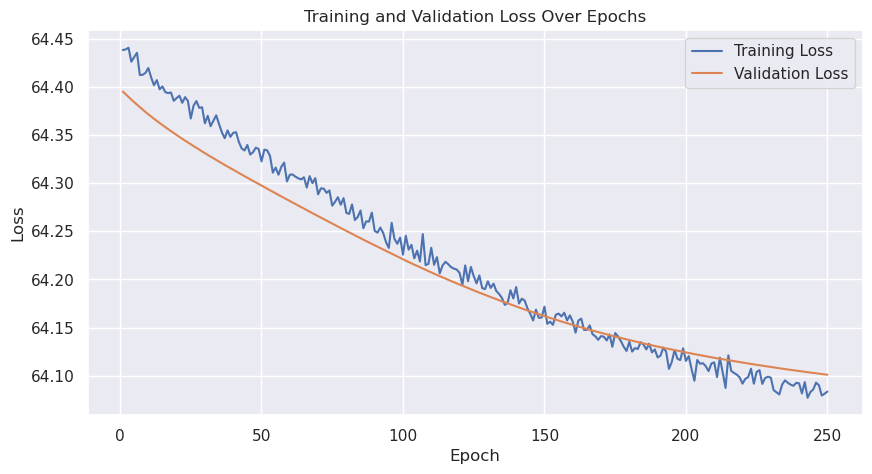

In [17]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Test

Test loss: 64.1965


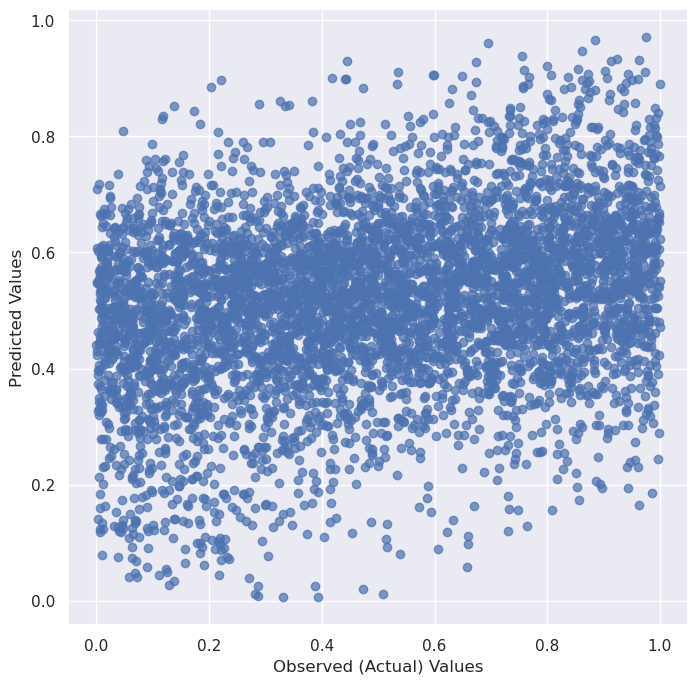

In [18]:
# Testing phase
model.eval()

# Evaluate the model and gather predictions
test_loss = 0
test_preds = []
test_labels = []
num_test_batches = ceil(features_test.shape[0] / batch_size)

with torch.no_grad():
    for idx in range(0, features_test.shape[0], batch_size):
        # Get the data
        inputs = torch.from_numpy(features_test[idx:idx + batch_size, :]).float()
        labels = torch.from_numpy(targets_test[idx:idx + batch_size, :]).float()
        
        # Move to device
        inputs.to(device)
        labels.to(device)
        
        # Perform a forward pass
        outputs = model(inputs)
        
        # Compute loss and add it
        test_loss += criterion(outputs, labels)
        
        # Store predictions and labels
        test_preds.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
# Average the loss over the number of batches
test_loss = test_loss / num_test_batches
print(f"Test loss: {test_loss:.4f}")

# Plot the losses
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_preds, alpha=0.7)
plt.xlabel('Observed (Actual) Values')
plt.ylabel('Predicted Values')
plt.show()

# Testing with a circuit

We will test the trained model with a discretized normal distribution. We expect the model to predict 50% probabilities for every peg in the circuit.

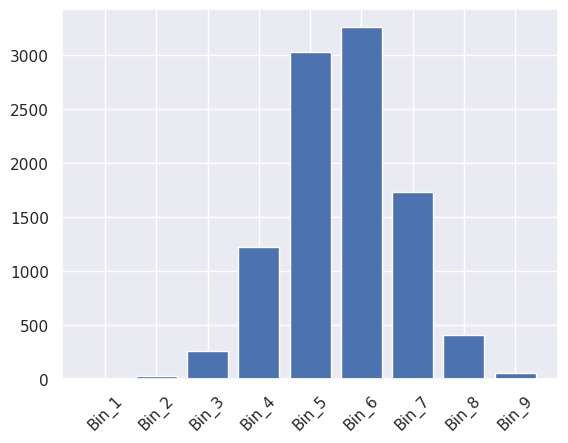

In [19]:
# Get a random values sampled from a normal distribution
norm_samples = norm.rvs(loc=0, scale=1, size=10000, random_state=1925)

# Discretize the values into 9 bins
discrete_norm = discretize(data=norm_samples, bins=9)

# Plot the values of the discretized sample
plt.bar([f"Bin_{i+1}" for i in range(len(discrete_norm))], discrete_norm)
plt.xticks(rotation=45)
plt.show()

In [20]:
# Get the data into the desired format
scaled_discrete_norm = scaler.transform(discrete_norm.reshape((1, -1)))
inputs = torch.from_numpy(scaled_discrete_norm).float()
inputs.to(device)

# Get model's predictions
model.eval()

with torch.no_grad():
    outputs = model(inputs)
    
outputs

tensor([[0.7022, 0.5552, 0.6564, 0.4365, 0.6296, 0.5457, 0.5075, 0.5585, 0.5268,
         0.5489, 0.4396, 0.4777, 0.6106, 0.6029, 0.4571, 0.4489, 0.5024, 0.5561,
         0.5964, 0.5225, 0.4951, 0.4632, 0.4465, 0.4582, 0.5323, 0.6614, 0.5318,
         0.4166, 0.4456, 0.3808, 0.4729, 0.5117, 0.6218, 0.5150, 0.4242, 0.4052]])

In [21]:
# Test the circuit with the provided outputs as probabilities (this may take a while)
p_vals = outputs.flatten().tolist()
qc = qgb.build_galton_circuit(levels=9, num_shots=10000, bias=p_vals)
obs_probs = qc()

In [72]:
# Define useful variables for the plot
num_obs = len(obs_probs)
num_qubits = int(log2(num_obs))
bins_dict = {f"Bin_{i+1}": obs_probs[2**i] for i in range(num_qubits)}
x_pos = list(range(num_qubits))

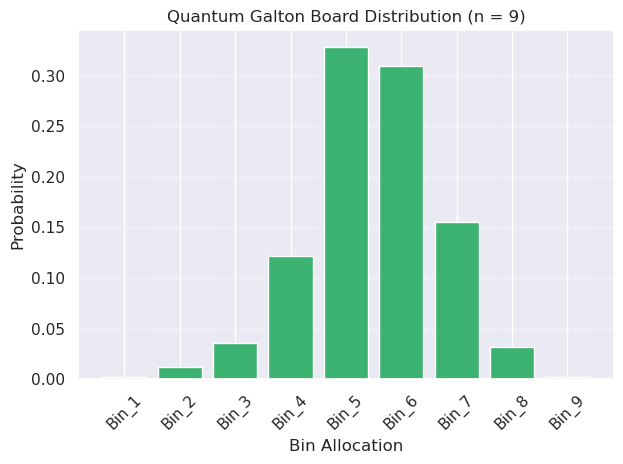

In [73]:
# Plot
plt.bar(x_pos, list(bins_dict.values()), color='mediumseagreen')
plt.xticks(x_pos, list(bins_dict.keys()), rotation=45)
plt.xlabel("Bin Allocation")
plt.ylabel("Probability")
plt.title("Quantum Galton Board Distribution (n = 9)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()